### Cab-Driver Agent

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import sys
import os

py_file_location = "/content/drive/My Drive"
sys.path.append(os.path.abspath(py_file_location))

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model

from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver


#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("/content/drive/MyDrive/TM.npy")

In [ ]:
print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())

Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


#### Tracking the state-action pairs for checking convergence


In [ ]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [ ]:
#Defining the agent class
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01      
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.0005 
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and the action space (0,1) (0,2) (0,3) (0,4).
        self.track_state = np.array(env.state_encod_arch2([0,0,0])).reshape(1, 36)

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, time):
        # Write your code here:
        # Decay in ε after we generate each sample from the environment       
        self.epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*time)

        # Get the requests for the current cab driver state
        possible_actions_index,actions = env.requests(state)

        # get action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cab this will randomly choose an action between 0 and 1
            return random.choice(possible_actions_index)
        # if generated random number is greater than ε, choose the action which has max Q-value
        else:
            state_encoded = env.state_encod_arch2(state)
            state_value = np.array(state_encoded).reshape(1, self.state_size)
            q_value = self.model.predict(state_value)

            q_value = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_value)]


    def append_sample(self, state, action, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
   
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            
            #Initialize input of output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, terminal_states = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, terminal_state = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)
                update_output[i] = env.state_encod_arch2(next_state)
                actions.append(action)
                rewards.append(reward)
                terminal_states.append(terminal_state)
                
                
            # Write your code from here
            # 1. Predict the target from earlier model Q(s,a)
            target = self.model.predict(update_input)
              
            # 2. Get the target for the Q-network Q(s',a)
            target_qval = self.model.predict(update_output)
                
            #3. Update your 'update_output' and 'update_input' batch r + gamma * Q(s',a)
            # update the target values
            for i in range(self.batch_size):
                if terminal_states[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state 
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])

    def save(self, name):
        self.model.save(name)

In [ ]:
Episodes = 1000
episode_time=30*24 #30 days before which car has to be recharged
rewards_per_episode, episodes = [], []
m = 5
t = 24
d = 7

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

#initialize the DQN agent
agent = DQNAgent(action_size=action_size, state_size=state_size)    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### DQN block

In [ ]:
start_time = time.time()

for episode in range(Episodes):

    env = CabDriver()
 
    action_size ,state_size,state =  env.reset()
    
    terminal_state = False
    score = 0
    total_time = 0    
    
    while not terminal_state:
        

        action = agent.get_action(state, episode)
        

        reward,next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        
        if(total_time >= episode_time):
       
            terminal_state = True
        else:
          
            agent.append_sample(state, action, reward, next_state, terminal_state)
        
            agent.train_model()
        
     
            score += reward
            state = next_state
    
    rewards_per_episode.append(score)
    episodes.append(episode)
    
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon))
       
        agent.save_tracking_states()
        
    if ((episode + 1) % 100 == 0):

        print("Saving Model {}".format(episode))
        agent.save(name="CarPol_model.h5")
        pickle.dump(agent,open('model.pkl','wb'))

elapsed_time = time.time() - start_time
print("Total time : ",elapsed_time/60)

episode 9, reward 24.0, memory_length 1374, epsilon 0.9955101547284723
episode 19, reward -317.0, memory_length 2000, epsilon 0.990545076993076
episode 29, reward -139.0, memory_length 2000, epsilon 0.985604762686195
episode 39, reward -67.0, memory_length 2000, epsilon 0.9806890882997144
episode 49, reward -261.0, memory_length 2000, epsilon 0.9757979309415181
episode 59, reward 98.0, memory_length 2000, epsilon 0.9709311683324178
episode 69, reward 185.0, memory_length 2000, epsilon 0.9660886788030947
episode 79, reward -90.0, memory_length 2000, epsilon 0.9612703412910584
episode 89, reward 149.0, memory_length 2000, epsilon 0.9564760353376198
episode 99, reward -50.0, memory_length 2000, epsilon 0.9517056410848808
Saving Model 99
INFO:tensorflow:Assets written to: ram://0ccfbbe1-b6ae-48ef-885c-20a1f2180a9d/assets
episode 109, reward -239.0, memory_length 2000, epsilon 0.9469590392727365
episode 119, reward 69.0, memory_length 2000, epsilon 0.9422361112358941
episode 129, reward -35

In [ ]:
agent.save(name="model_weights.pkl")

INFO:tensorflow:Assets written to: model_weights.pkl/assets


In [ ]:
actions_space

### Tracking Convergence

In [ ]:
agent.states_tracked

[181.47379,
 288.9204,
 306.89923,
 120.3202,
 182.55125,
 206.7985,
 319.66168,
 330.675,
 737.01746,
 332.70312,
 386.4262,
 411.55313,
 429.28775,
 340.75446,
 409.7416,
 657.69946,
 379.85208,
 451.21332,
 516.77075,
 449.22278,
 434.8523,
 419.51376,
 383.01535,
 542.71356,
 471.9795,
 555.6648,
 579.9167,
 620.5841,
 534.46466,
 1239.7854,
 732.4925,
 657.93787,
 457.0718,
 642.78174,
 504.06818,
 629.82153,
 587.6653,
 533.2592,
 633.9688,
 439.07343,
 458.80148,
 527.88904,
 546.9026,
 545.7842,
 589.0229,
 479.47458,
 604.5824,
 599.4496,
 925.5355,
 464.84598,
 525.0116,
 697.2842,
 700.41925,
 828.2799,
 549.9655,
 693.4649,
 721.292,
 624.87946,
 1347.1947,
 747.4142,
 552.5633,
 561.1914,
 645.8668,
 532.10333,
 517.75525,
 567.4608,
 568.1787,
 591.41547,
 538.5973,
 552.9868,
 543.41376,
 580.14984,
 527.9645,
 609.9209,
 691.30505,
 709.1025,
 1228.7775,
 422.83978,
 512.88885,
 842.92065,
 1052.217,
 830.9939,
 817.01544,
 759.9352,
 540.91125,
 400.7992,
 429.91202,
 

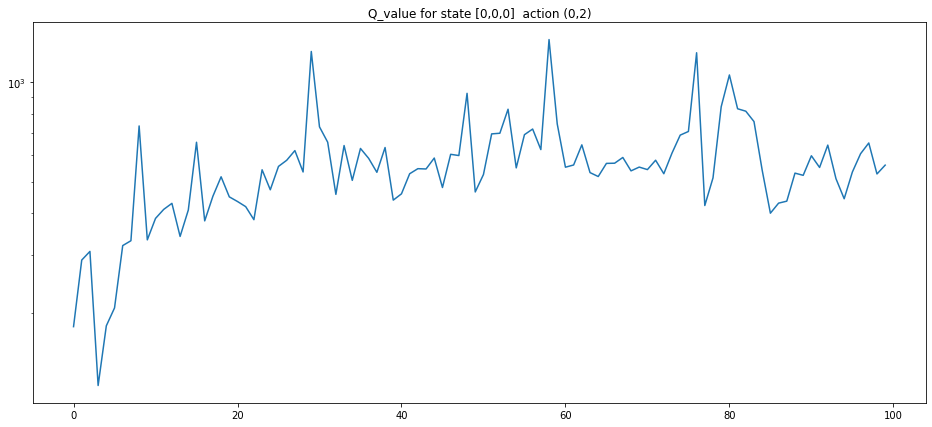

In [ ]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [ ]:
rewards_tracked = [rewards_per_episode[i] for i in range(len(rewards_per_episode)) if (i % 4 == 0)]


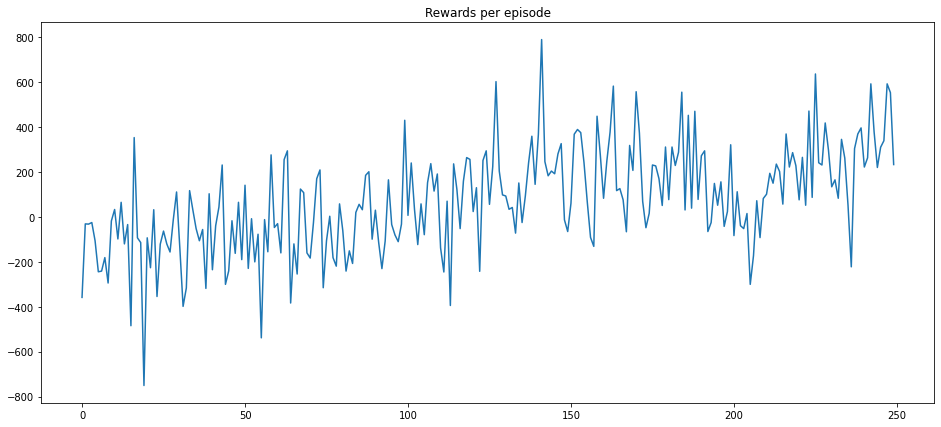

In [ ]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(rewards_tracked)))
plt.plot(xaxis,np.asarray(rewards_tracked))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

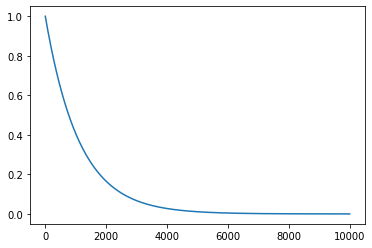

In [ ]:
plt.plot(time, epsilon)
plt.show()

In [ ]:
!zip -r /content/model_weights.zip /content/model_weights.pkl

  adding: content/model_weights.pkl/ (stored 0%)
  adding: content/model_weights.pkl/assets/ (stored 0%)
  adding: content/model_weights.pkl/variables/ (stored 0%)
  adding: content/model_weights.pkl/variables/variables.index (deflated 62%)
  adding: content/model_weights.pkl/variables/variables.data-00000-of-00001 (deflated 33%)
  adding: content/model_weights.pkl/keras_metadata.pb (deflated 87%)
  adding: content/model_weights.pkl/saved_model.pb (deflated 88%)
